In [1]:
from pathlib import Path
from pprint import pformat
import logging
import json
import re
import sys
from math import ceil

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import dynamic_yaml
import yaml

logging.basicConfig(format='%(levelname)-8s [%(filename)s] %(message)s',
                    level=logging.INFO)
matplotlib_logger = logging.getLogger("matplotlib")
matplotlib_logger.setLevel(logging.ERROR)
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False

time: 399 ms (started: 2023-02-28 23:49:53 +08:00)


# Find the most differ graph

In [2]:
sys.path.append("/workspace/correlation-change-predict/ywt_library")
current_dir = Path(__file__).parent
data_config_path = current_dir/"../config/data_config.yaml"
with open(data_config_path) as f:
    data = dynamic_yaml.load(f)
    data_cfg = yaml.full_load(dynamic_yaml.dump(data))

# ## Data implement & output setting & testset setting
# data implement setting
data_implement = "SP500_20082017_CORR_SER_REG_CORR_MAT_HRCHY_11_CLUSTER"  # watch options by operate: logging.info(data_cfg["DATASETS"].keys())
# train set setting
train_items_setting = "-train_train"  # -train_train|-train_all
# setting of name of output files and pictures title
output_file_name = data_cfg["DATASETS"][data_implement]['OUTPUT_FILE_NAME_BASIS'] + train_items_setting
# setting of output files
logging.info(f"===== file_name basis:{output_file_name} =====")
graph_data_dir = Path(data_cfg["DIRS"]["PIPELINE_DATA_DIR"])/f"{output_file_name}-graph_data"
graph_arr = np.load(graph_data_dir/f"corr_s1_w10_graph.npy")  # each graph consist of 66 node & 66^2 edges

stride = 12
train_arr = graph_arr[:int(len(graph_arr)*0.9)]
val_arr = graph_arr[int(len(graph_arr)*0.9):int(len(graph_arr)*0.95)]
test_arr = graph_arr[int(len(graph_arr)*0.95):]
train_diff_arr = train_arr[stride:] - train_arr[:-stride] # this is what I want
max_diff_ind = np.argmax(train_diff_arr.sum(axis=1).sum(axis=1))
logging.info(f"train_arr.shape: {train_arr.shape}")
logging.info(f"train_diff_arr.shape: {train_diff_arr.shape}")
logging.info(f"train_arr[0][0][:5]: \n{train_arr[0][0][:5]}")
logging.info(f"max_difference index of train_arr: {max_diff_ind}")
logging.info(f"train_diff_arr[{max_diff_ind}][0]: \n{train_diff_arr[max_diff_ind][0]}")
logging.info(f"train_arr[{max_diff_ind}][0]: \n{train_arr[max_diff_ind][0]}")
logging.info(f"train_arr[{max_diff_ind+stride}][0]: \n{train_arr[max_diff_ind+stride][0]}")

INFO     [2586445745.py] ===== file_name basis:sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train =====
INFO     [2586445745.py] train_arr.shape: (2247, 66, 66)
INFO     [2586445745.py] train_diff_arr.shape: (2235, 66, 66)
INFO     [2586445745.py] train_arr[0][0][:5]: 
[ 1.         -0.7845055  -0.35839325  0.23613496  0.03113716]
INFO     [2586445745.py] max_difference index of train_arr: 1902
INFO     [2586445745.py] train_diff_arr[1902][0]: 
[ 0.          1.0869076   0.80756148  1.10147876  0.27583836  1.4311462
  0.31798946  0.77423705  1.49131504  0.06400973  0.35000056  1.02577531
  1.54352727  1.31498903  0.71837798  1.37400844  0.53681407  1.7463089
  1.50096265  0.55053766  0.14724983  1.23417145  1.64226315  1.54879715
  1.8150735   1.3664364   1.2108747   0.38212797  0.62011885  1.26466605
  0.10248986  1.46270668  0.23049925  0.21841866  1.6698941   1.70031337
  1.75067461  1.8054871   0.2055773   0.15378154  0.24515754  0.01484384
  1.7717906   1.38432037  0.

time: 162 ms (started: 2023-02-28 23:49:54 +08:00)


# Draw the training process

In [3]:
def mts_corr_ad_estimation(log_path_list):
    for log_path in log_path_list:
        with open(log_path, "r") as source:
            log_dict = json.load(source)

        if log_dict.get('model_structure'):
            gin_l = len(re.findall("\(\d\)GINConv", log_dict.get('model_structure')))
            gin_h = int(re.search("(\(\d\)\:\sGINConv.*\n.*)(out_features\=)(\d*)", log_dict.get('model_structure')).group(3))
            gru_l = int(re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure'))[0][-1] if re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure')) else 1)
            gru_h = int(re.search("(\(gru1\)\:\sGRU\(\d*\,)\s(\d*)", log_dict.get('model_structure')).group(2))
        else:
            gin_l = None
            gin_h = None
            gru_l = None
            gru_h = None
        corr_info = [p for p in log_path.parts if p.startswith("corr")][0]
        best_epoch = log_dict['best_val_epoch'] if log_dict.get('best_val_epoch') else 500
        min_val_loss = min(log_dict['val_loss_history'])
        tr_batch = log_dict.get('train_batch') if log_dict.get('train_batch') else None
        batchs_per_epoch = log_dict.get('batchs_per_epoch')
        tr_loss = log_dict.get('train_loss_history')
        val_loss = log_dict.get('val_loss_history')
        pred_embeds = np.array(log_dict.get('graph_embeds_history').get('graph_embeds_pred')[:batchs_per_epoch*2]\
                               + [([np.nan]*(gin_l*gin_h)) for _ in range(20)]\
                               + log_dict.get('graph_embeds_history').get('graph_embeds_pred')[-batchs_per_epoch*2:])
        y_embeds = np.array(log_dict.get('graph_embeds_history').get('y_graph_embeds')[:batchs_per_epoch*2]\
                            + [([np.nan]*(gin_l*gin_h)) for _ in range(20)]\
                            + log_dict.get('graph_embeds_history').get('y_graph_embeds')[-batchs_per_epoch*2:])
        # if corr_info != "corr_s1_w10" or gin_l != 1 or gin_h != 3 or gru_l != 1 or gru_h != 8:
        if corr_info != "corr_s1_w10" or tr_batch != 12:
            continue
        logging.info(f"file_name:{log_path.parts}")
        logging.info(f'{corr_info} with tr_batch({tr_batch}) input to model with gin_l{gin_l}-gin_h{gin_h}-gru_l{gru_l}-gru_h{gru_h}; min val-loss:{min_val_loss:8f}')
        # plot results
        fig, axs = plt.subplots(ncols=2, nrows=6, figsize=(25,50))
        fig.suptitle(f'{corr_info} with tr_batch({tr_batch}) input to model with gin_l{gin_l}-gin_h{gin_h}-gru_l{gru_l}-gru_h{gru_h}; min val-loss:{min_val_loss:8f}', fontsize=30)
        gs = axs[0, 0].get_gridspec()
        # remove the upper axes
        for ncol in range(2):
            for ax in axs[3:, ncol]:
                ax.remove()
        axbig = fig.add_subplot(gs[3:, :2])
        axbig.set_xticks([]); axbig.set_yticks([])
        axbig.annotate(text=f"{log_dict.get('model_structure').__str__()}",
                       xy=(0.15, 0.5), bbox={'facecolor': 'green', 'alpha': 0.4, 'pad': 5},
                       fontsize=20, fontfamily='monospace', xycoords='axes fraction', va='center')
        axs[0, 0].plot(tr_loss)
        axs[0, 1].plot(val_loss)
        axs[1, 0].plot(tr_loss[max(0, best_epoch-100):max(201, best_epoch+101)])
        axs[1, 1].plot(tr_loss[max(0, best_epoch-100):max(201, best_epoch+101)])
        axs[2, 0].plot(pred_embeds, linewidth=5, alpha=0.3)
        axs[2, 0].axvline(x=batchs_per_epoch, ymin=pred_embeds[~np.isnan(pred_embeds)].min(), ymax=pred_embeds[~np.isnan(pred_embeds)].max(),
                          color='k', linewidth=5, linestyle='--', alpha=0.3)
        axs[2, 0].axvline(x=batchs_per_epoch*3+20, ymin=pred_embeds[~np.isnan(pred_embeds)].min(), ymax=pred_embeds[~np.isnan(pred_embeds)].max(),
                          color='k', linewidth=5, linestyle='--', alpha=0.3)
        axs[2, 1].plot(y_embeds, linewidth=5, alpha=0.3)
        axs[2, 1].axvline(x=batchs_per_epoch, ymin=y_embeds[~np.isnan(y_embeds)].min(), ymax=y_embeds[~np.isnan(y_embeds)].max(),
                          color='k', linewidth=5, linestyle='--', alpha=0.3)
        axs[2, 1].axvline(x=batchs_per_epoch*3+20, ymin=y_embeds[~np.isnan(y_embeds)].min(), ymax=y_embeds[~np.isnan(y_embeds)].max(),
                          color='k', linewidth=5, linestyle='--', alpha=0.3)
        axs[0, 0].set_title('train_loss_history', fontsize=30)
        axs[0, 1].set_title('val_loss_history', fontsize=30)
        axs[1, 0].set_title(f"train_loss_history-epoch{(max(0, best_epoch-100), max(200, best_epoch+100))}", fontsize=30)
        axs[1, 1].set_title(f"val_loss_history-epoch{(max(0, best_epoch-100), max(200, best_epoch+100))}", fontsize=30)
        axs[2, 0].set_title(f'pred_embeds-[{pred_embeds.shape[1]}]', fontsize=30)
        axs[2, 1].set_title(f'y_embeds-[{y_embeds.shape[1]}]', fontsize=30)
        axs[1, 0].set_xticks(ticks=range(0, 201, 20), labels=[f"{x:02d}" for x in range(max(0, best_epoch-100), max(201, best_epoch+101), 20)])
        axs[1, 1].set_xticks(ticks=range(0, 201, 20), labels=[f"{x:02d}" for x in range(max(0, best_epoch-100), max(201, best_epoch+101), 20)])
        for ax in axs.ravel():
            ax.yaxis.offsetText.set_fontsize(30)
            ax.tick_params(axis='both', which='major', labelsize=24)
        fig.tight_layout(rect=(0, 0, 1, 0.97))
        plt.show()
        plt.close()

time: 3.09 ms (started: 2023-02-28 23:49:54 +08:00)


INFO     [3092572908.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w10', 'train_logs', 'epoch_754-20230227112450.json')
INFO     [3092572908.py] corr_s1_w10 with tr_batch(12) input to model with gin_l1-gin_h3-gru_l3-gru_h8; min val-loss:0.027458


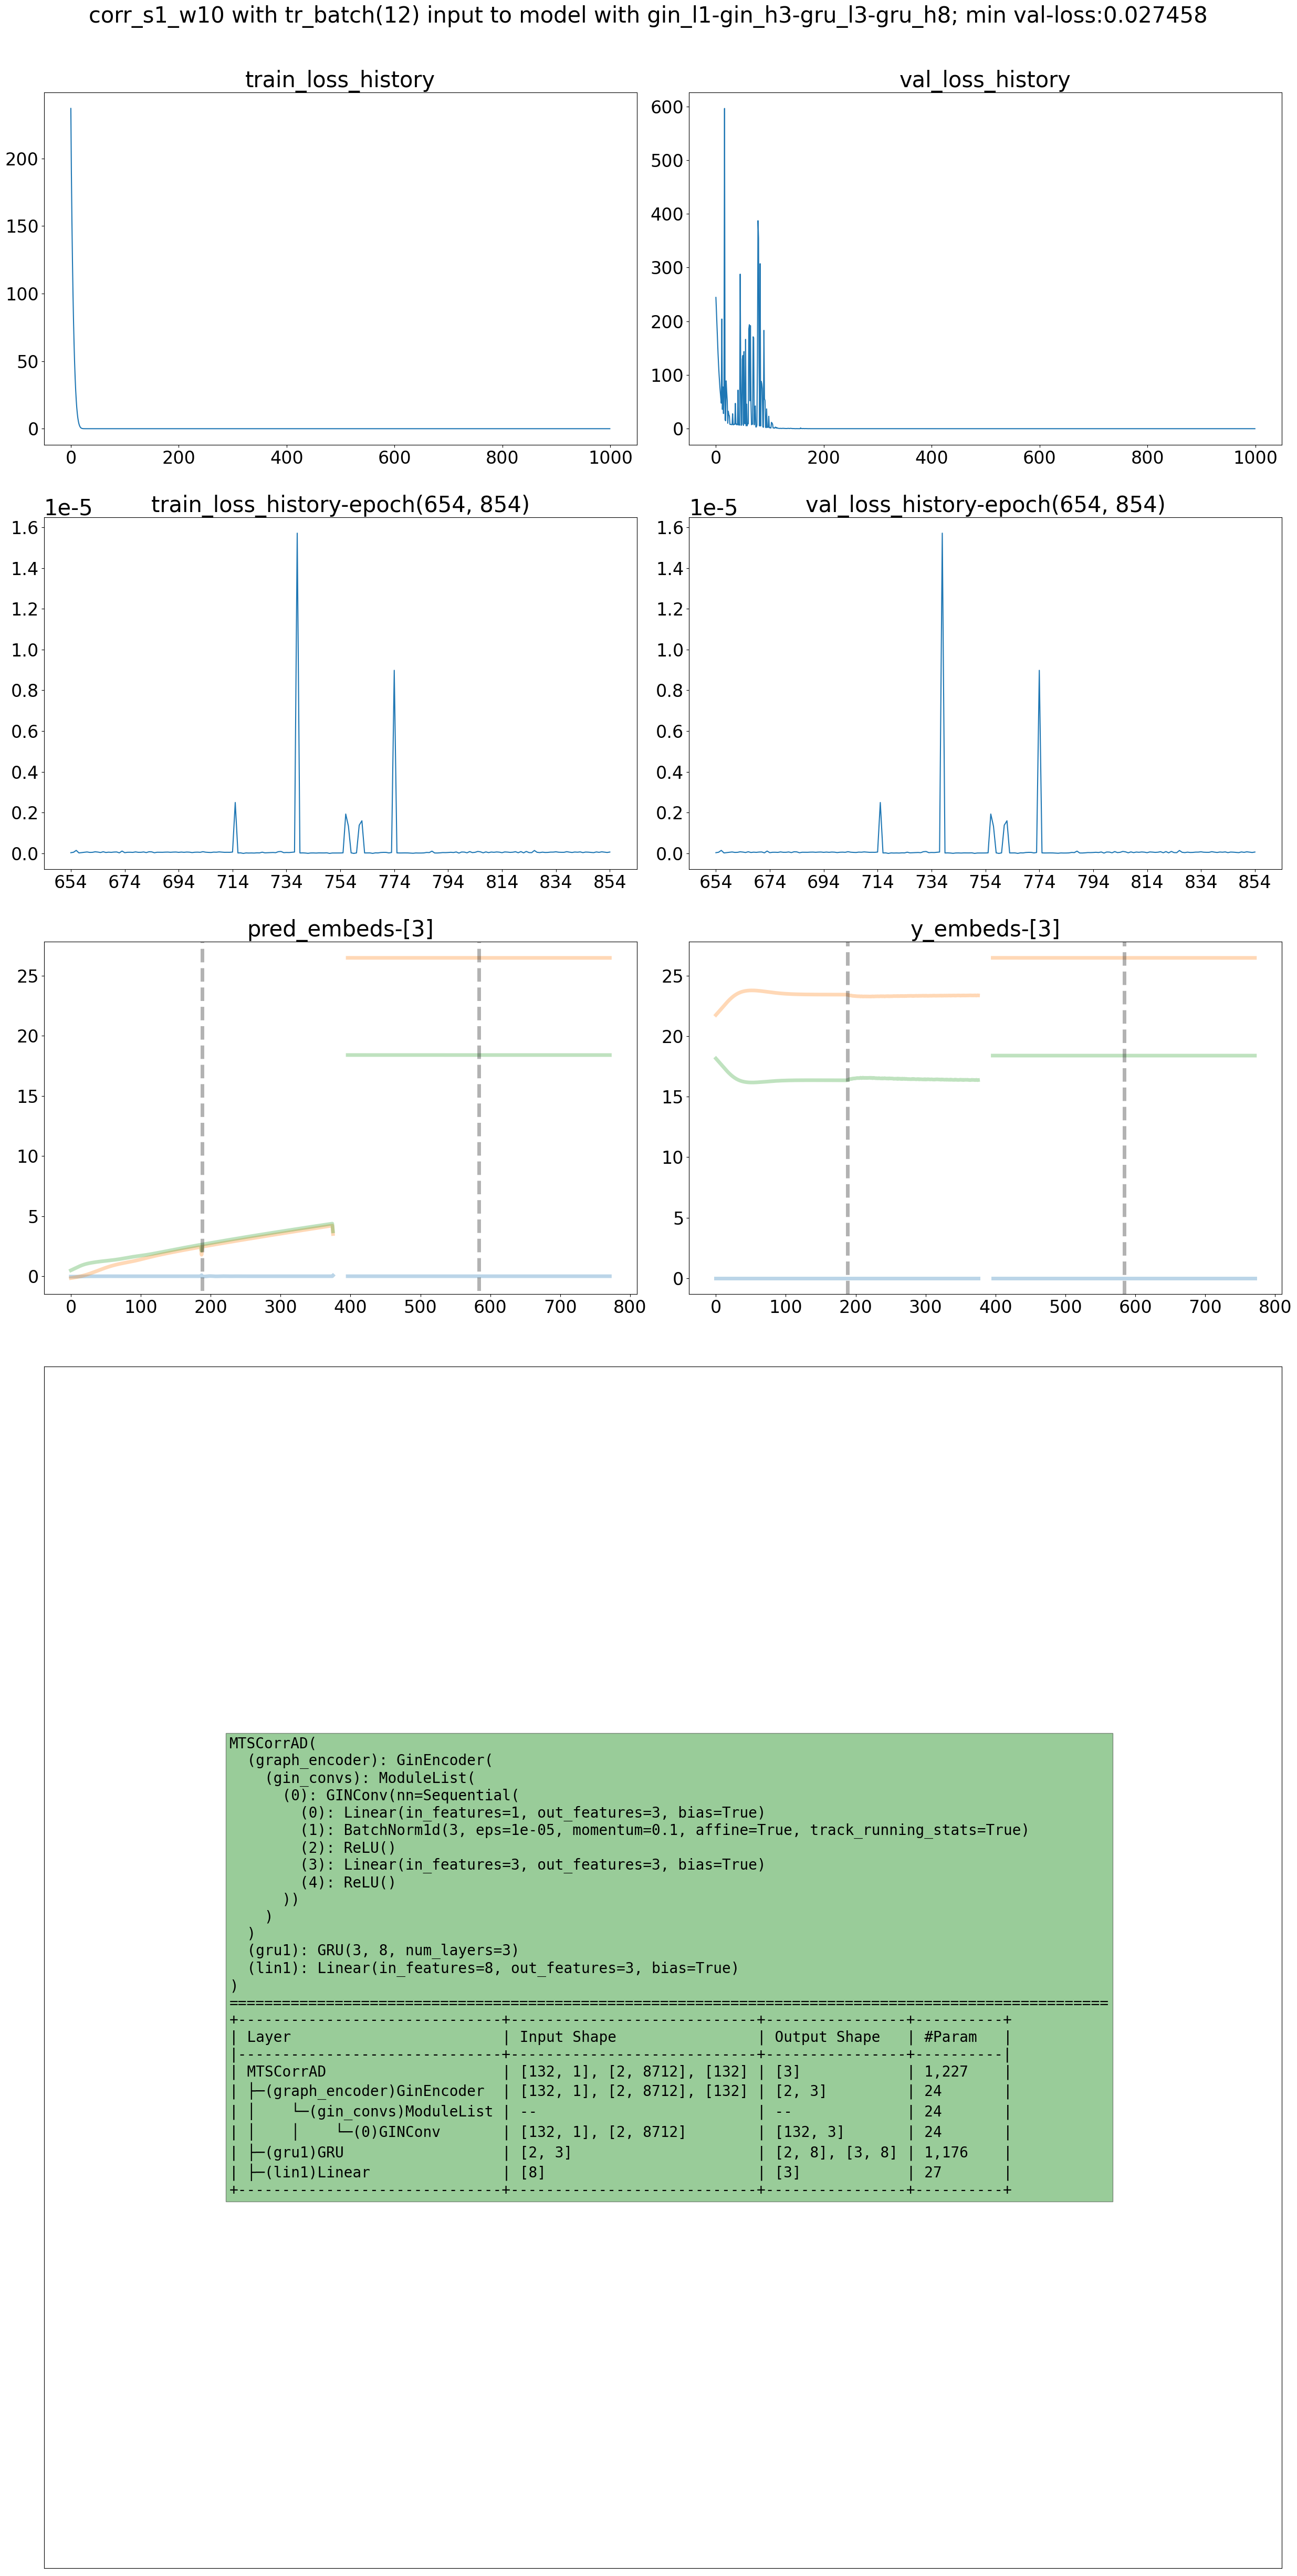

INFO     [3092572908.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w10', 'train_logs', 'epoch_988-20230227115106.json')
INFO     [3092572908.py] corr_s1_w10 with tr_batch(12) input to model with gin_l1-gin_h3-gru_l1-gru_h32; min val-loss:0.005996


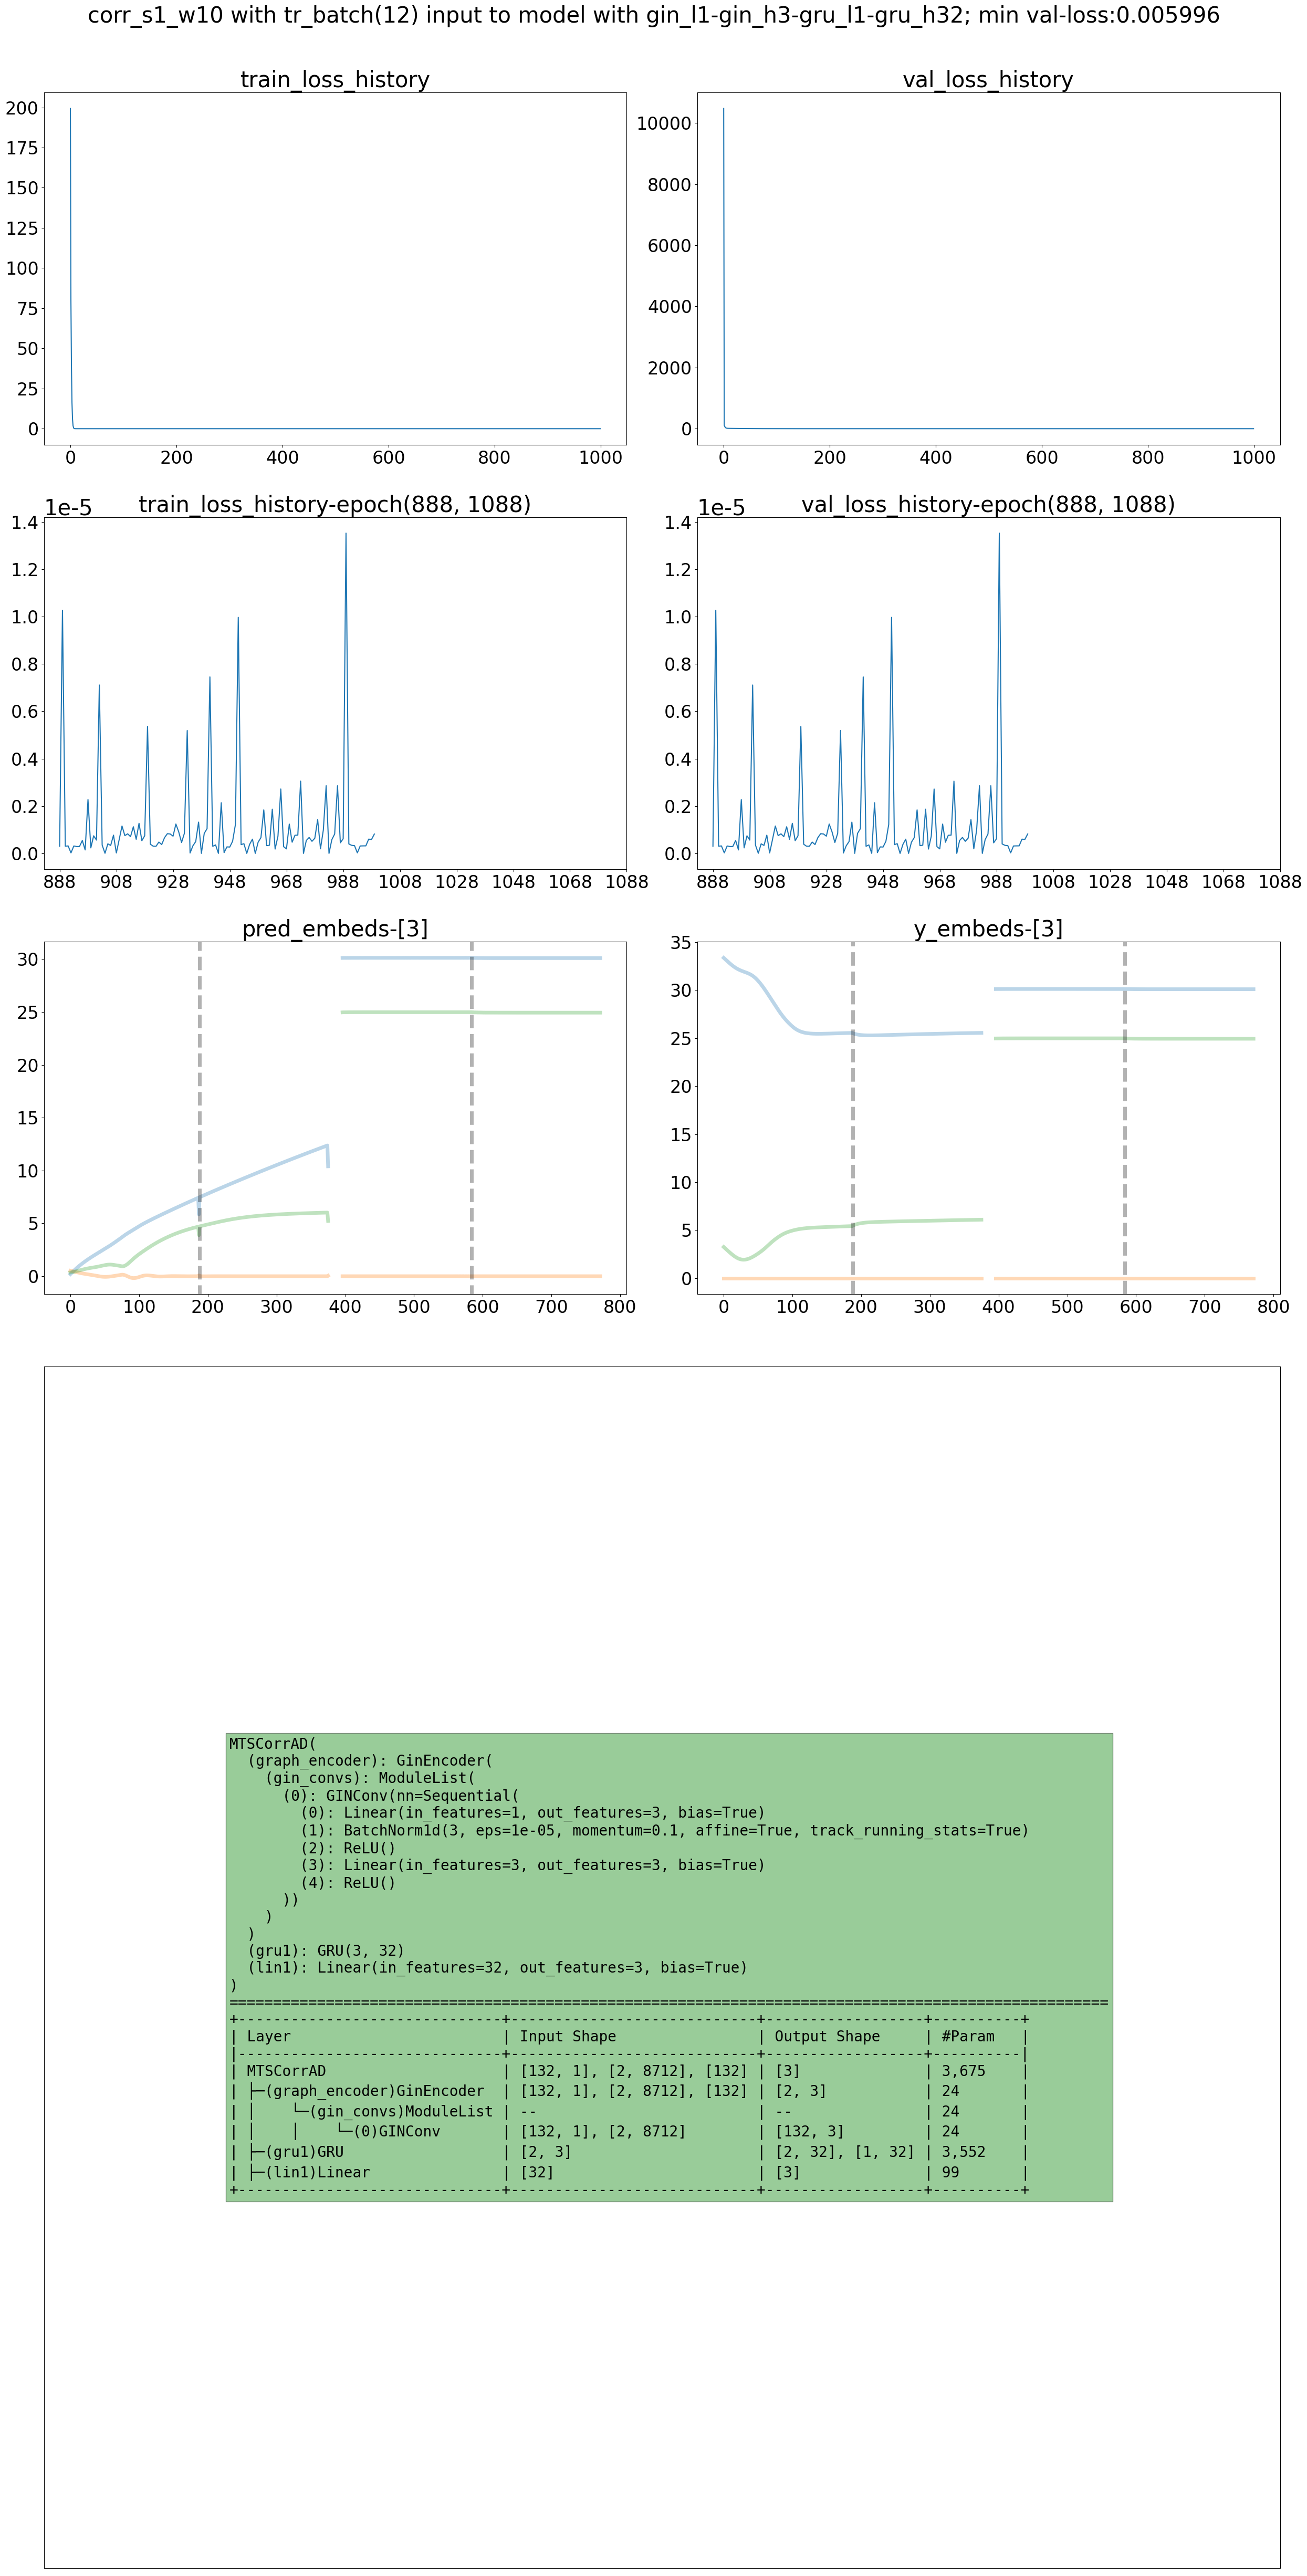

INFO     [3092572908.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w10', 'train_logs', 'epoch_213-20230227174639.json')
INFO     [3092572908.py] corr_s1_w10 with tr_batch(12) input to model with gin_l1-gin_h32-gru_l1-gru_h8; min val-loss:0.028030


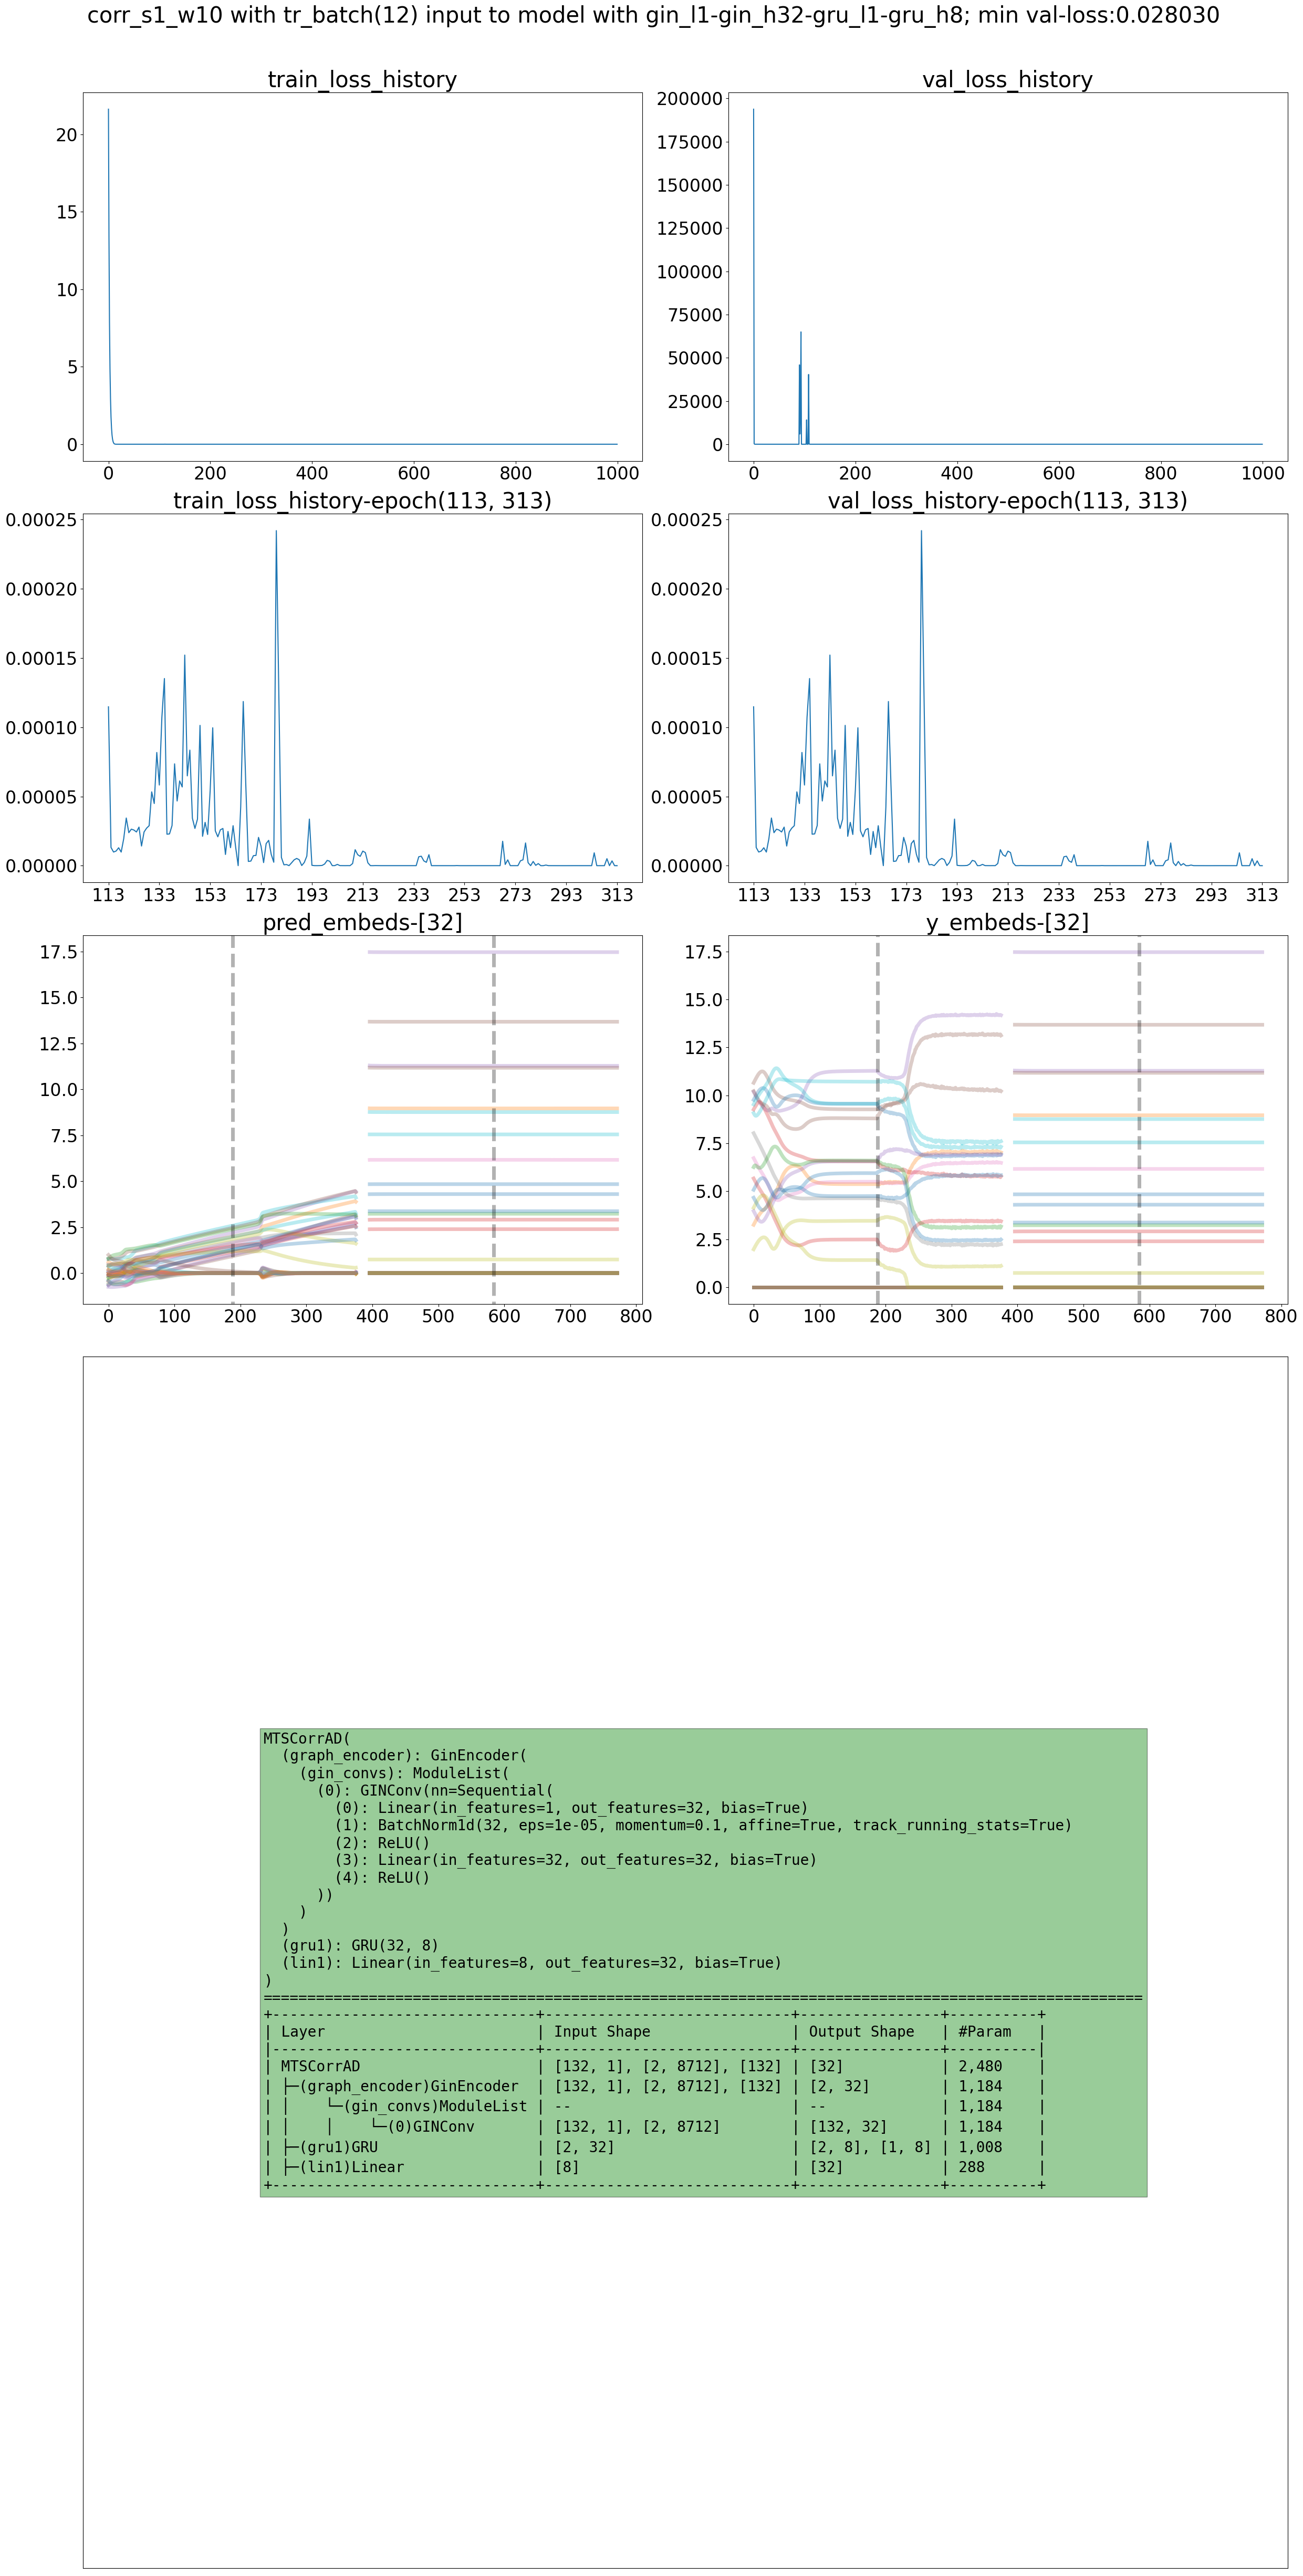

INFO     [3092572908.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w10', 'train_logs', 'epoch_188-20230227105734.json')
INFO     [3092572908.py] corr_s1_w10 with tr_batch(12) input to model with gin_l3-gin_h3-gru_l1-gru_h8; min val-loss:5209.922363


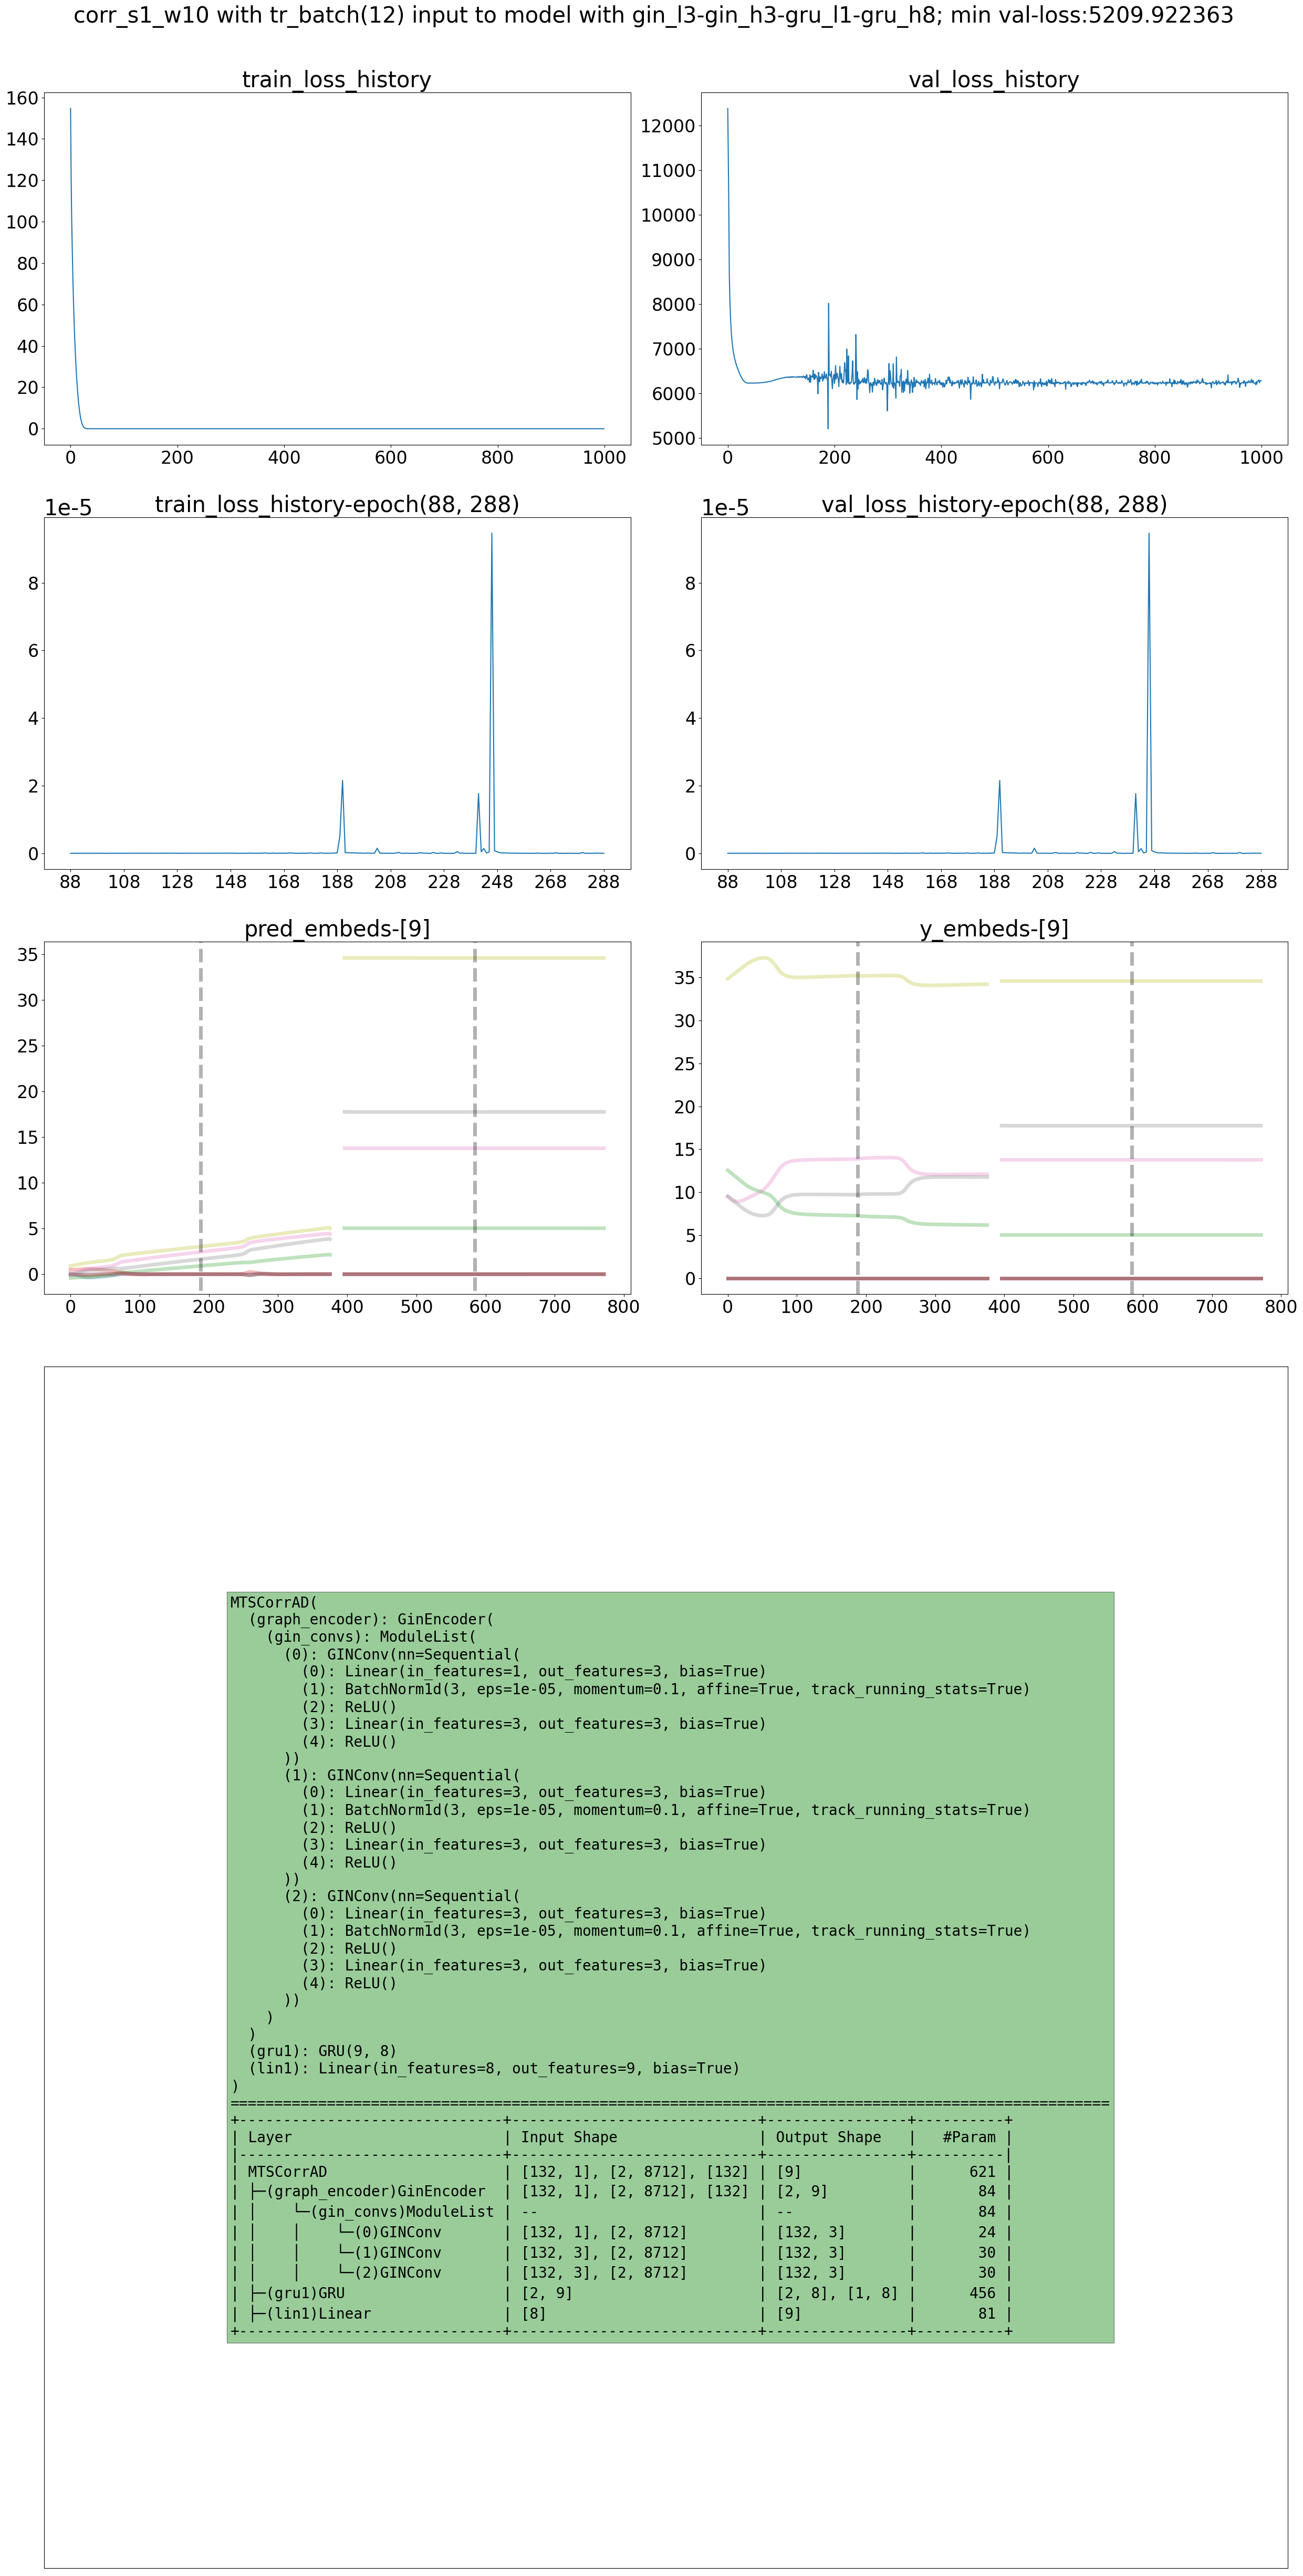

INFO     [3092572908.py] file_name:('save_models', 'sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train', 'corr_s1_w10', 'train_logs', 'epoch_674-20230227021740.json')
INFO     [3092572908.py] corr_s1_w10 with tr_batch(12) input to model with gin_l1-gin_h3-gru_l1-gru_h8; min val-loss:0.000029


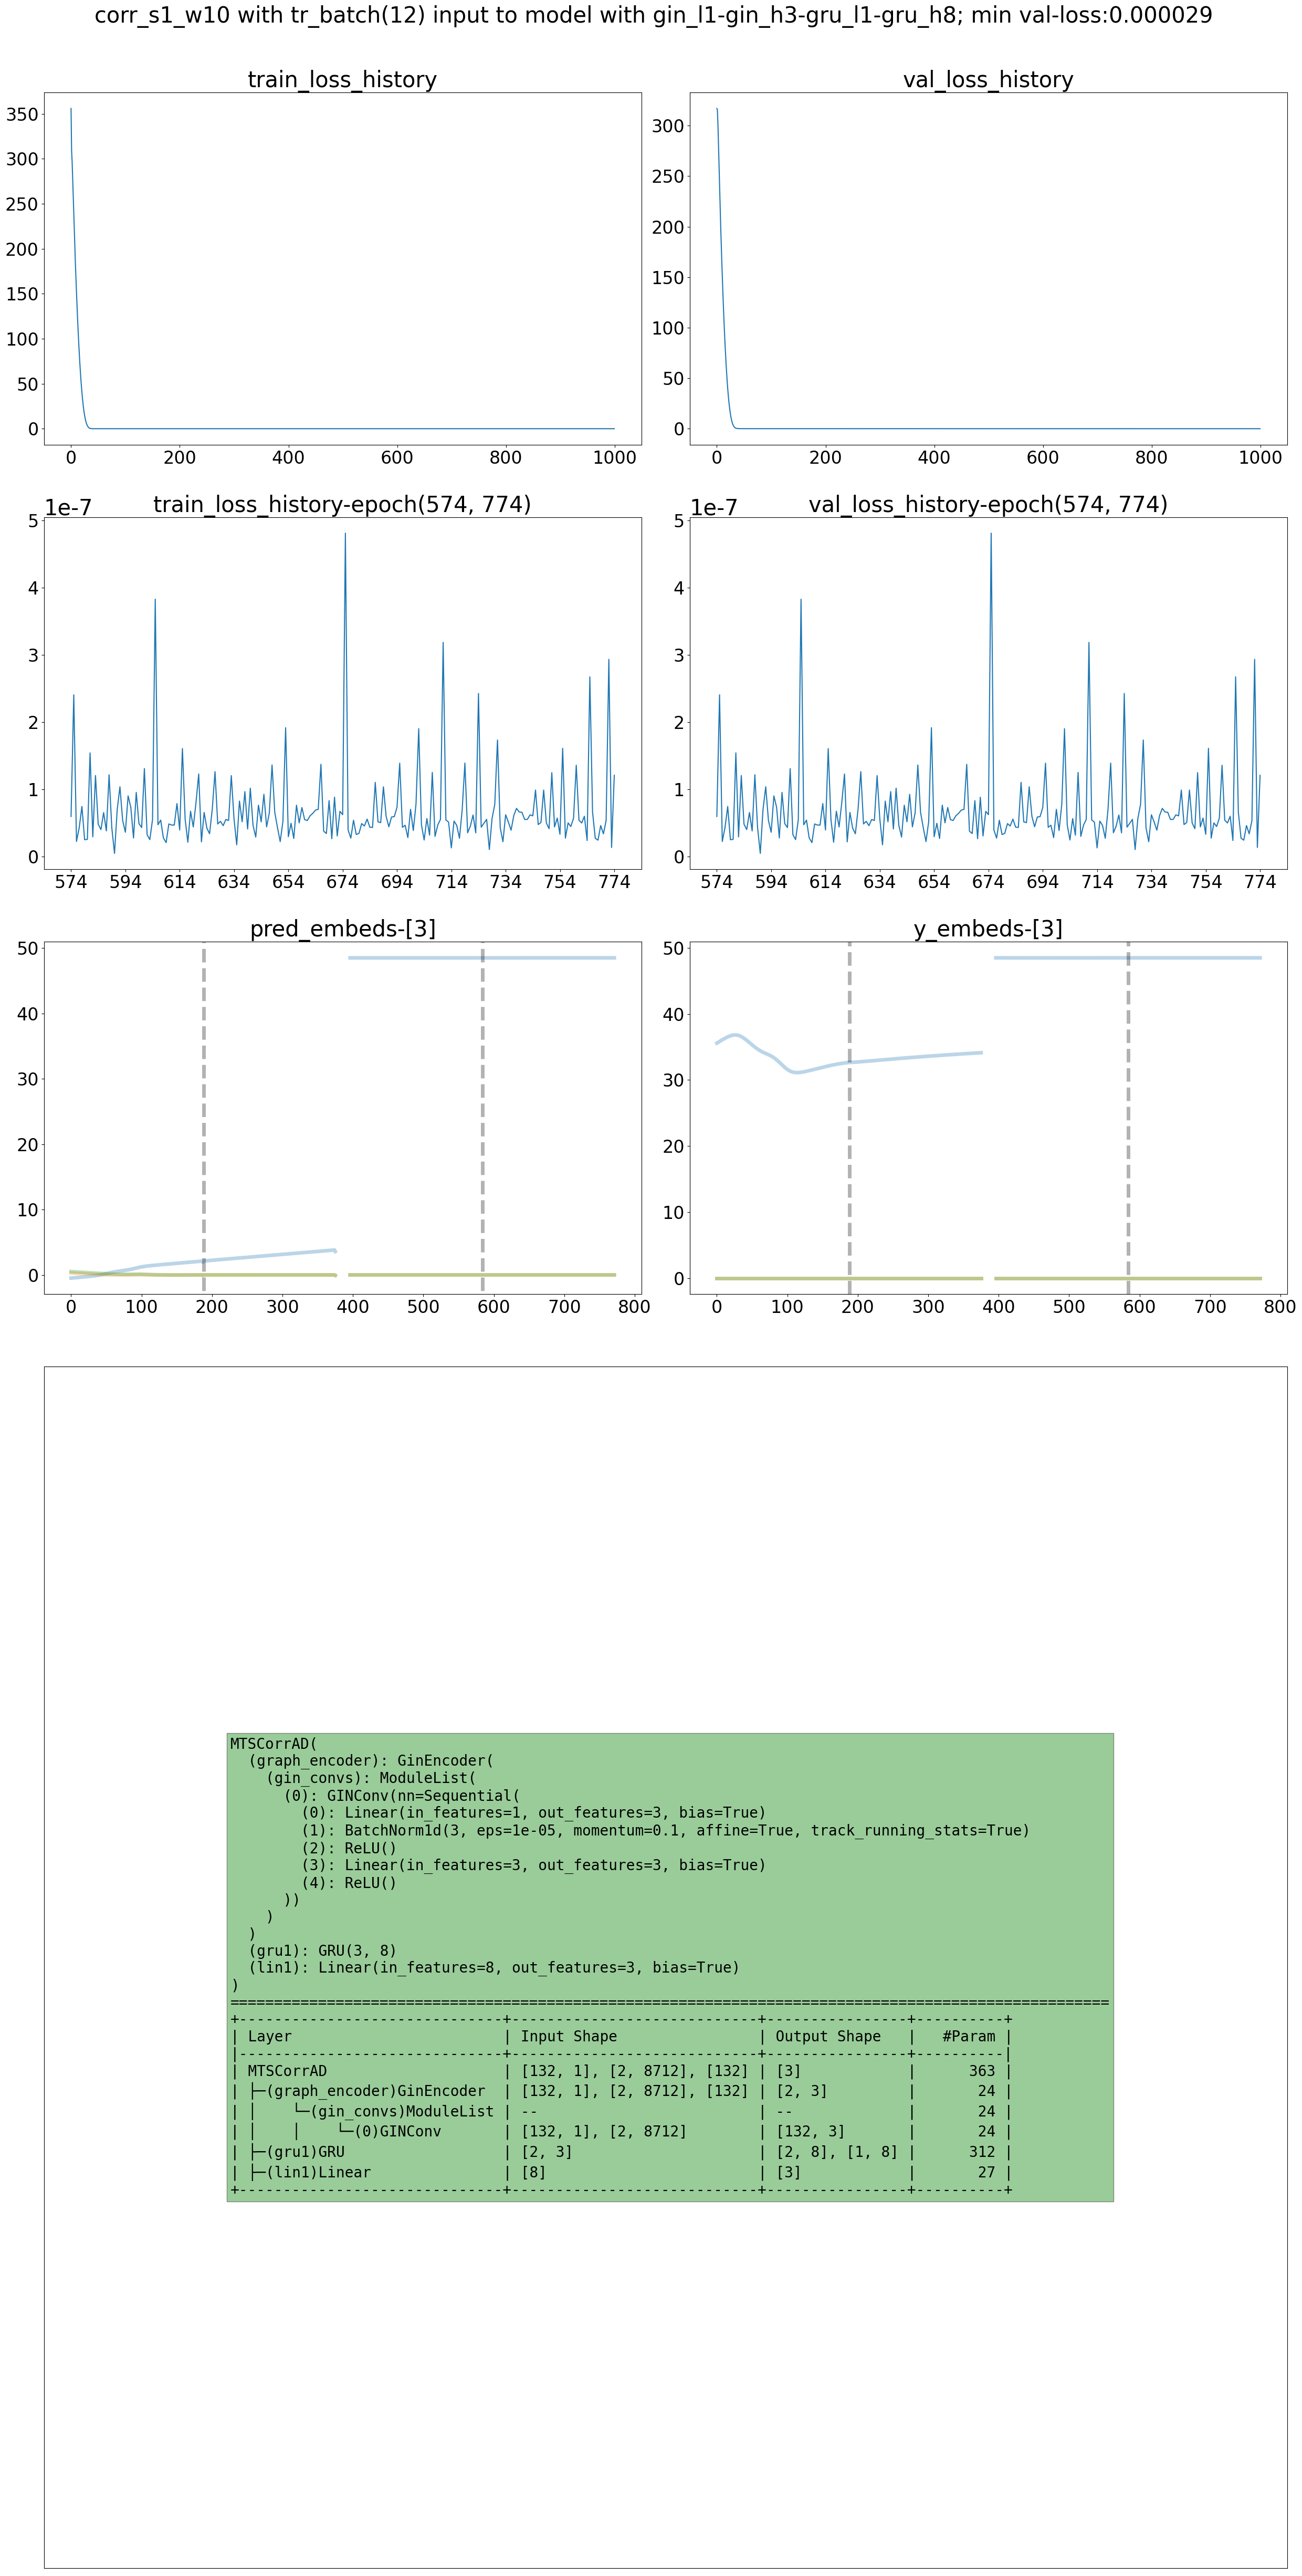

time: 14.1 s (started: 2023-02-28 23:49:54 +08:00)


In [4]:
mts_corr_model_log_dir = Path("./save_models/sp500_20082017_corr_ser_reg_corr_mat_hrchy_11_cluster-train_train/")
log_path_list = mts_corr_model_log_dir.glob("./*[!deprecated][!.ipynb_checkpoints]*/train_logs/*[!.ipynb_checkpoints]*[.json]")
mts_corr_ad_estimation(log_path_list)

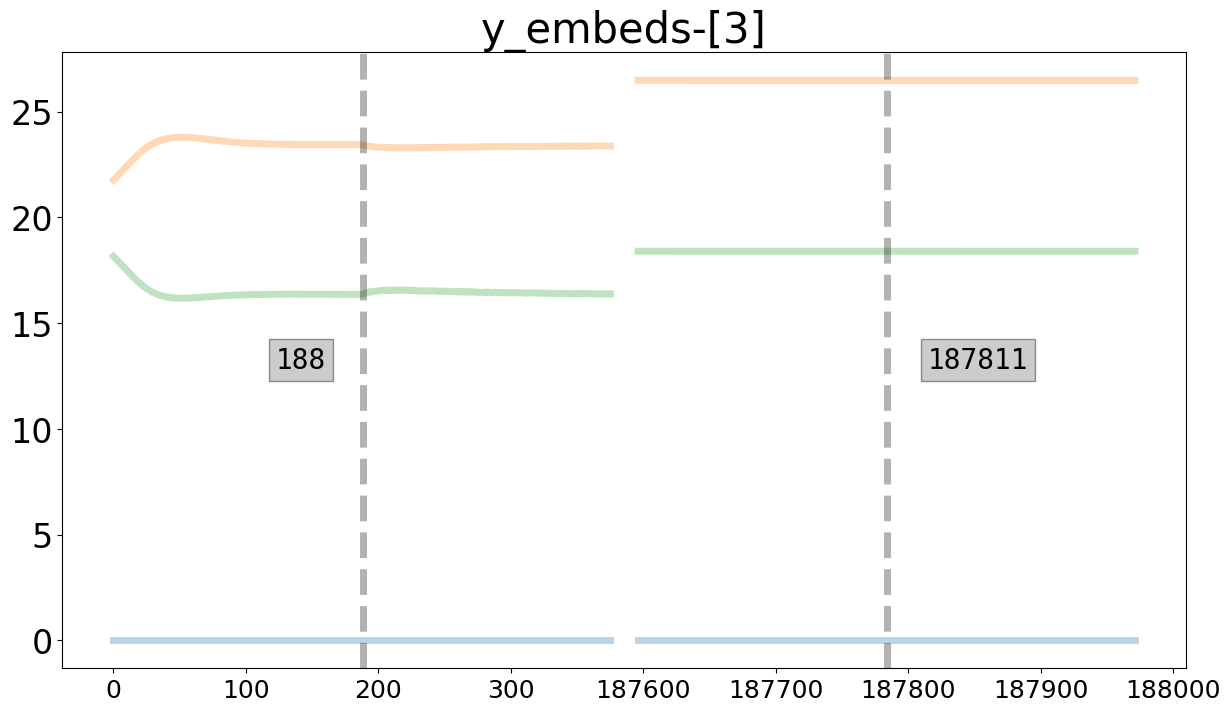

time: 594 ms (started: 2023-02-28 23:50:08 +08:00)


In [5]:
specific_log_p = mts_corr_model_log_dir/f"corr_s1_w10/train_logs/epoch_754-20230227112450.json"

with open(specific_log_p, "r") as source:
    log_dict = json.load(source)

if log_dict.get('model_structure'):
    gin_l = len(re.findall("\(\d\)GINConv", log_dict.get('model_structure')))
    gin_h = int(re.search("(\(\d\)\:\sGINConv.*\n.*)(out_features\=)(\d*)", log_dict.get('model_structure')).group(3))
    gru_l = int(re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure'))[0][-1] if re.search("(\(gru1\)\:.*)(num_layers\=)(\d*)", log_dict.get('model_structure')) else 1)
    gru_h = int(re.search("(\(gru1\)\:\sGRU\(\d*\,)\s(\d*)", log_dict.get('model_structure')).group(2))
else:
    gin_l = None
    gin_h = None
    gru_l = None
    gru_h = None
corr_info = [p for p in specific_log_p.parts if p.startswith("corr")][0]
best_epoch = log_dict['best_val_epoch'] if log_dict.get('best_val_epoch') else 500
min_val_loss = min(log_dict['val_loss_history'])
tr_batch = log_dict.get('train_batch') if log_dict.get('train_batch') else None
batchs_per_epoch = log_dict.get('batchs_per_epoch')
tr_loss = log_dict.get('train_loss_history')
val_loss = log_dict.get('val_loss_history')
pred_embeds = np.array(log_dict.get('graph_embeds_history').get('graph_embeds_pred')[:batchs_per_epoch*2]\
                       + [([np.nan]*(gin_l*gin_h)) for _ in range(20)]\
                       + log_dict.get('graph_embeds_history').get('graph_embeds_pred')[-batchs_per_epoch*2:])
y_embeds = np.array(log_dict.get('graph_embeds_history').get('y_graph_embeds')[:batchs_per_epoch*2]\
                    + [([np.nan]*(gin_l*gin_h)) for _ in range(20)]\
                    + log_dict.get('graph_embeds_history').get('y_graph_embeds')[-batchs_per_epoch*2:])
plt.figure(figsize=(14.5, 8))
plt.plot(y_embeds, linewidth=5, alpha=0.3)
plt.axvline(x=batchs_per_epoch, ymin=y_embeds[~np.isnan(y_embeds)].min(), ymax=y_embeds[~np.isnan(y_embeds)].max(),
                  color='k', linewidth=5, linestyle='--', alpha=0.3)
plt.axvline(x=batchs_per_epoch*3+20, ymin=y_embeds[~np.isnan(y_embeds)].min(), ymax=y_embeds[~np.isnan(y_embeds)].max(),
                  color='k', linewidth=5, linestyle='--', alpha=0.3)
plt.annotate(text=f"188", xy=(0.19, 0.5),
             bbox={'facecolor': 'gray', 'alpha': 0.4, 'pad': 5},
             fontsize=20, fontfamily='monospace', xycoords='axes fraction', va='center')
plt.annotate(text=f"187811", xy=(0.77, 0.5),
             bbox={'facecolor': 'gray', 'alpha': 0.4, 'pad': 5},
             fontsize=20, fontfamily='monospace', xycoords='axes fraction', va='center')
plt.title(f'y_embeds-[{y_embeds.shape[1]}]', fontsize=30)
xticks_label = list(range(0, 301, 100)) + list(range(187600, 188001, 100))
plt.xticks(ticks=list(range(0, 801, 100)), labels=xticks_label, fontsize=18)
plt.yticks(fontsize=24)
plt.show()
plt.close()